# Virtual linac guide

- [Introduction](#Introduction)
- [Helper functions](#Helper-functions)
- [AWS (Amazon web service)](#AWS)
- [VirtuaLinac API](#VirtuaLinac-API)
- [Plot .dose data](#Plot-.dose-data)
- [Calculation with my phantom](#Calculation-with-my-phantom)
- [Terminate](#Terminate)

# Introduction

ALWAYS NEED TO EDIT INSTANCE SECURITY GROUP > INCOMING > HTTP > FROM MY IP

Follow guide on http://radiotherapyresearchtools.com/doc/api_tutorial.html

For parsing HTML https://www.crummy.com/software/BeautifulSoup/

In [147]:
%load_ext watermark
%watermark -a 'Robin Cole' -u -d -v -p numpy,pandas,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Robin Cole 
last updated: 2016-09-21 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1


In [203]:
import boto3
import requests
import re
from bs4 import BeautifulSoup
import vl_api_helper as vl   # Daren helper files
from time import localtime, strftime  # to print time
import plotdose as vlplt
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os
%matplotlib inline

# Helper functions

In [38]:
def get_jobs():
    r = requests.get(url + '/usage') 
    for line in r.text.split('\n'):
        if 'Number of jobs' in line:
            print(line)
            print(strftime("%H:%M:%S", localtime()))

In [137]:
def print_files(url):    # Helper function to print list of files on server
    resp = requests.get(url + '/phspfiles') # get page with list of output files
    soup = BeautifulSoup(resp.text, 'html.parser')   
    my_list = []
    for link in soup.find_all('a'):   # get all links
        my_list.append(link.get('href'))
    results = [k for k in my_list if '/vl_files/' in k]  # get only links from vl_files
    for item in results:
        pprint.pprint(re.sub('/vl_files/', '', item))  # use pprint and strip vl_files

In [205]:
def download_file(url, file):    # my own helper function to download files
    r = requests.get(url + '/vl_files/' + file, stream=True)
    f = open(file, 'wb')     # use 'wb' write binary
    f.write(r.content)
    f.close()
    print(file, " downloaded at ", strftime("%H:%M:%S", localtime()), " File size (Bytes)", os.path.getsize(file))

# AWS

Logon to AWS, start virtualinac instance, edit security group to accept incoming HTTP

In [106]:
ec2=boto3.resource('ec2')
instances = ec2.instances.filter(Filters=
    [{'Name': 'instance-state-name', 'Values': ['running'] }])

In [107]:
dns_names = []
for instance in instances:
        print(instance.public_dns_name)
        dns_names.append(instance.public_dns_name)
url = 'http://' + dns_names[0]

ec2-75-101-242-192.compute-1.amazonaws.com


# VirtuaLinac API

Basic check of availability using requests

In [117]:
get_jobs()

<p><b>Number of jobs:</b> 0 </p>
11:52:04


In [255]:
params1 = {
    'filename'     : 'api_test_1',
    'code_version' : 0,
    'physics_list' : 0,
    'beam_type'    : 0,
    'range_cut' : 10,
    'energy'       : 6.84,
    'energy_spread' : 0.6,
    'spot_size_x'  : 0.7,
    'spot_size_y'  : 0.7,
    'beam_divergence_x' : 0.0,
    'beam_divergence_y' : 0.0,
    'jaw_position_y1' : -20,
    'jaw_position_y2' :  20,
    'jaw_position_x1' : -20,
    'jaw_position_x2' :  20,
    'phantom_bool' : 'True',
    'phantom_size_x' : 500,
    'phantom_size_y' : 500,
    'phantom_size_z' : 400,
    'phantom_voxels_x' : 125,
    'phantom_voxels_y' : 125,
    'phantom_voxels_z' : 100,
    'phantom_position_x' : 0,
    'phantom_position_y' : 0,
    'phantom_position_z' : -5,
    'incident_particles' : 10000000,    # increased from 10000
    'brem_splitting' : None,   # increased from none
    'splitting_factor' : None,
    'phsp_record'  : None
}

In [256]:
r = requests.post(url, params=params1)   # Submit calculation

In [258]:
get_jobs()

<p><b>Number of jobs:</b> 0 </p>
12:39:19


params1 took less than a minute to complete

In [259]:
print_files(url) # On calculation completion, get files 

'06e_x.dat'
'06e_z.dat'
'12e_x.dat'
'12e_z.dat'
'cylinder.phantom'
'gantry.xml'
'testing.dose'
'testing.mac'
'testing.output'
'tmp.phantom'


In [260]:
download_file(url, 'testing.dose') # download .dose file

testing.dose  downloaded at  12:39:25  File size (Bytes) 221680


# Plot .dose data

phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 39
Number of voxels in phantom.  nx: 50 ny: 50 nz: 40
i_max: 4


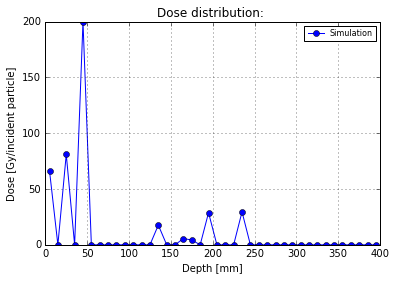

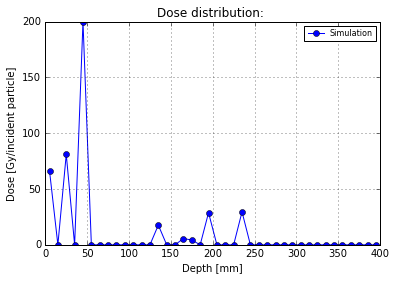

In [261]:
vlplt.plotdose('testing.dose', xplot=25, yplot=25, zplot=40, plotdir='z')   # xplot = Number of bins?

phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 6
Number of voxels in phantom.  nx: 50 ny: 50 nz: 40


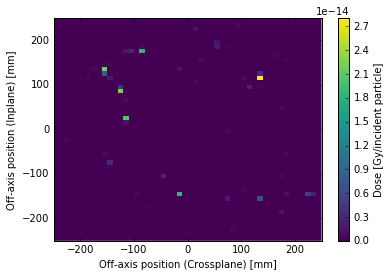

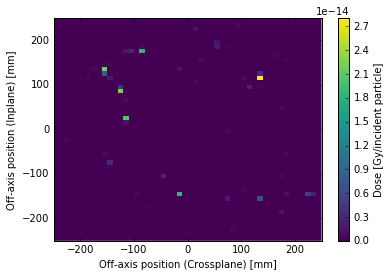

In [262]:
vlplt.plotdose('testing.dose', xplot=25, yplot=25, zplot=6, plotdir='z', dimension=2) 

<hr>

# Calculation with my phantom

I have run create_ct.py on my CT dataset to create tmp.phantom

http://radiotherapyresearchtools.com/doc/output.html#simulate-phantom-and-how-to-build-a-phantom

In [244]:
filename = 'tmp.phantom'
upload_files = {'file': open(filename, 'rb')}
r = requests.post(url + '/upload', files=upload_files)

In [245]:
# vlplt.plotdose(filename, xplot=250 , yplot=5, zplot=250, plotdir='z')  # Can plot phantom..

In [263]:
params2 = {
    'filename'     : 'api_test_1',
    'code_version' : 0,
    'physics_list' : 0,
    'beam_type'    : 0,
    'range_cut' : 10,
    'energy'       : 6.84,
    'energy_spread' : 0.6,
    'spot_size_x'  : 0.7,
    'spot_size_y'  : 0.7,
    'beam_divergence_x' : 0.0,
    'beam_divergence_y' : 0.0,
    'jaw_position_y1' : -20,
    'jaw_position_y2' :  20,
    'jaw_position_x1' : -20,
    'jaw_position_x2' :  20,
    'phantom_bool' : 'false',
    'phantom_file_name': 'tmp.phantom',
    'phantom_position_x' : 0,
    'phantom_position_y' : 0,
    'phantom_position_z' : -5,
    'incident_particles' : 100000000,
    'brem_splitting' : None,
    'splitting_factor' : None,
    'phsp_record'  : None
}

In [264]:
r = requests.post(url, params=params2)  # get page with list of output files

In [266]:
get_jobs()

<p><b>Number of jobs:</b> 0 </p>
12:40:06


In [267]:
download_file(url, 'testing.dose') # download .dose file

testing.dose  downloaded at  12:40:08  File size (Bytes) 219281


phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 39
Number of voxels in phantom.  nx: 50 ny: 50 nz: 40
i_max: 4


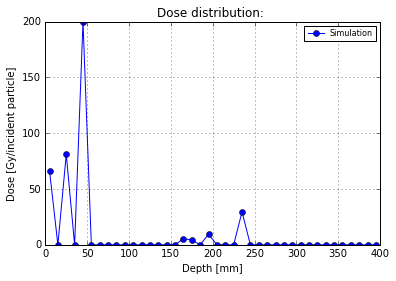

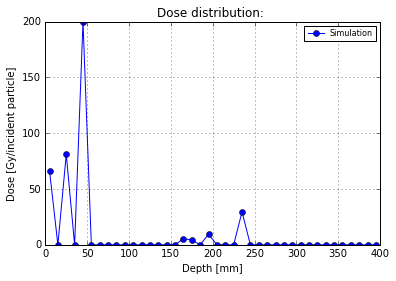

In [268]:
vlplt.plotdose('testing.dose', xplot=25, yplot=25, zplot=40, plotdir='z')   # xplot = Number of bins?

phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 6
Number of voxels in phantom.  nx: 50 ny: 50 nz: 40


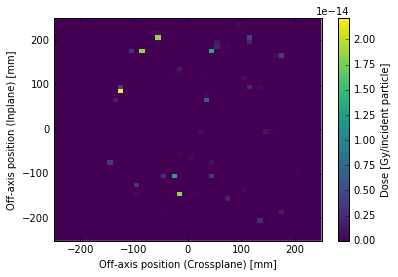

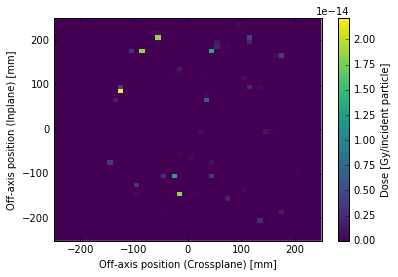

In [269]:
vlplt.plotdose('testing.dose', xplot=25, yplot=25, zplot=6, plotdir='z', dimension=2) 

# Terminate

In [270]:
instances.terminate()  # to terminate

[{'ResponseMetadata': {'HTTPHeaders': {'content-type': 'text/xml;charset=UTF-8',
    'date': 'Wed, 21 Sep 2016 11:40:52 GMT',
    'server': 'AmazonEC2',
    'transfer-encoding': 'chunked',
    'vary': 'Accept-Encoding'},
   'HTTPStatusCode': 200,
   'RequestId': 'cfbd90d7-f03a-4b01-8408-f7eead898fcc',
   'RetryAttempts': 0},
  'TerminatingInstances': [{'CurrentState': {'Code': 32,
     'Name': 'shutting-down'},
    'InstanceId': 'i-023dc2ad1d367c00e',
    'PreviousState': {'Code': 16, 'Name': 'running'}}]}]